# Inference plots - Predicted time series

This example builds on the [adaptive covariance MCMC example](https://github.com/pints-team/pints/blob/master/examples/sampling-adaptive-covariance-mcmc.ipynb), and shows you a different way to plot the results.

Inference plots:
* __Predicted time series__
* [Trace plots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-trace-plots.ipynb)
* [Autocorrelation](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-autocorrelation.ipynb)
* [Pairwise scatterplots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb)
* [Pairwise scatterplots with KDE](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-kde-plots.ipynb)

## Setting up an MCMC routine

See the adaptive covariance MCMC example for details.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Perform sampling using MCMC, with a single chain
x0 = real_parameters * 1.1
mcmc = pints.MCMCController(log_posterior, 1, [x0])
mcmc.set_max_iterations(4000)
mcmc.set_log_to_screen(False)

## Original data

First, we have a look at what to original data (that we're trying to fit) looks like:

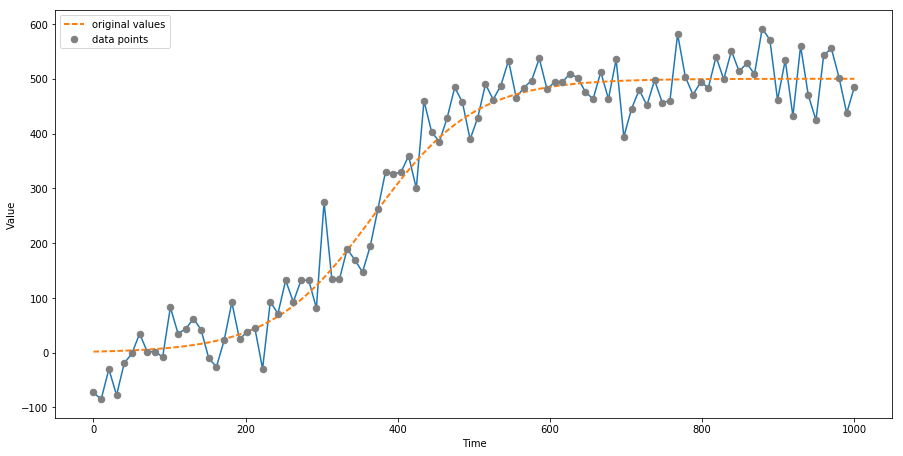

In [2]:
plt.figure(figsize=(15, 7.5))
plt.plot(times, values, color='#1f77b4')
plt.plot(times, org_values, '--', color='#ff7f0e', lw=2, label='original values')
plt.plot(times, values, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Predictions

Next, we run an MCMC routine and compare the predicted time series with the observed data. To do this, we use each parameter vector in the chain to run a simulation and then plot at the results.

In [3]:
# Run MCMC
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


In [4]:
# Select chain 0 and discard warm-up
chain = chains[0]
chain = chain[3000:]

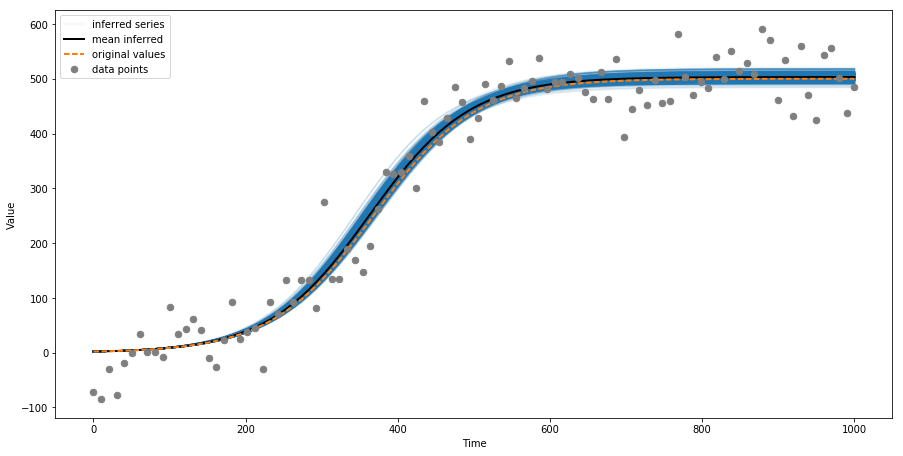

In [5]:
# Evaluate the model for the remaining parameter sets
new_values = []
for params in chain:
    new_values.append(problem.evaluate(params[:2]))
new_values = np.array(new_values)
mean_values = np.mean(new_values, axis=0)

# Plot them
plt.figure(figsize=(15, 7.5))
plt.plot(times, new_values[0], color='#1f77b4', alpha=0.05, label='inferred series')
for v in new_values[1:]:
    plt.plot(times, v, color='#1f77b4', alpha=0.05)
plt.plot(times, mean_values, color='black', lw=2, label='mean inferred')
plt.plot(times, org_values, '--', color='#ff7f0e', lw=2, label='original values')
plt.plot(times, values, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()